In [2]:
from IPython.display import HTML # type: ignore
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np
import numpy.linalg as la
from numpy.typing import NDArray
from tqdm.notebook import tqdm
import pandas as pd


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

from dcns.close_edges import get_close_edges
from dcns.graph_utils import node_attr_list_to_ndarray
from dcns.powerlaw import calc_powerlaw_multi

In [3]:
stops = pd.read_csv("./data/gtfs-dart-2023-02-28/stops.txt")

G_time = D3DiGraph(nx.read_gml("data/dart_stops_time.gml"))
G_freq = D3DiGraph(nx.read_gml("data/dart_stops_freq.gml"))
G_freq_over5000 = D3DiGraph(nx.read_gml("data/dart_stops_freq_over5000.gml"))
# Unpack node pos from list to numpy array
node_attr_list_to_ndarray(G_time, "pos")
node_attr_list_to_ndarray(G_freq, "pos")
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

# Graph styles
style = {"node_size": 5}
# d3.clear()
# d3.set_graph(G)
# d3.update
# d3.set_interactive(True)

In [54]:
%matplotlib widget
pos = nx.get_node_attributes(G_time, "pos")

comps = list(nx.weakly_connected_components(G_time))

# Plot each weakly-connected component in its own color
nx.draw_networkx(G_time, pos=pos, node_size=5, width=0.5, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(comps, colors):
    nx.draw_networkx(
        G_time.subgraph(component),
        pos=pos,
        node_color=[color],
        node_size=5,
        width=0.5,
        with_labels=False,
    )

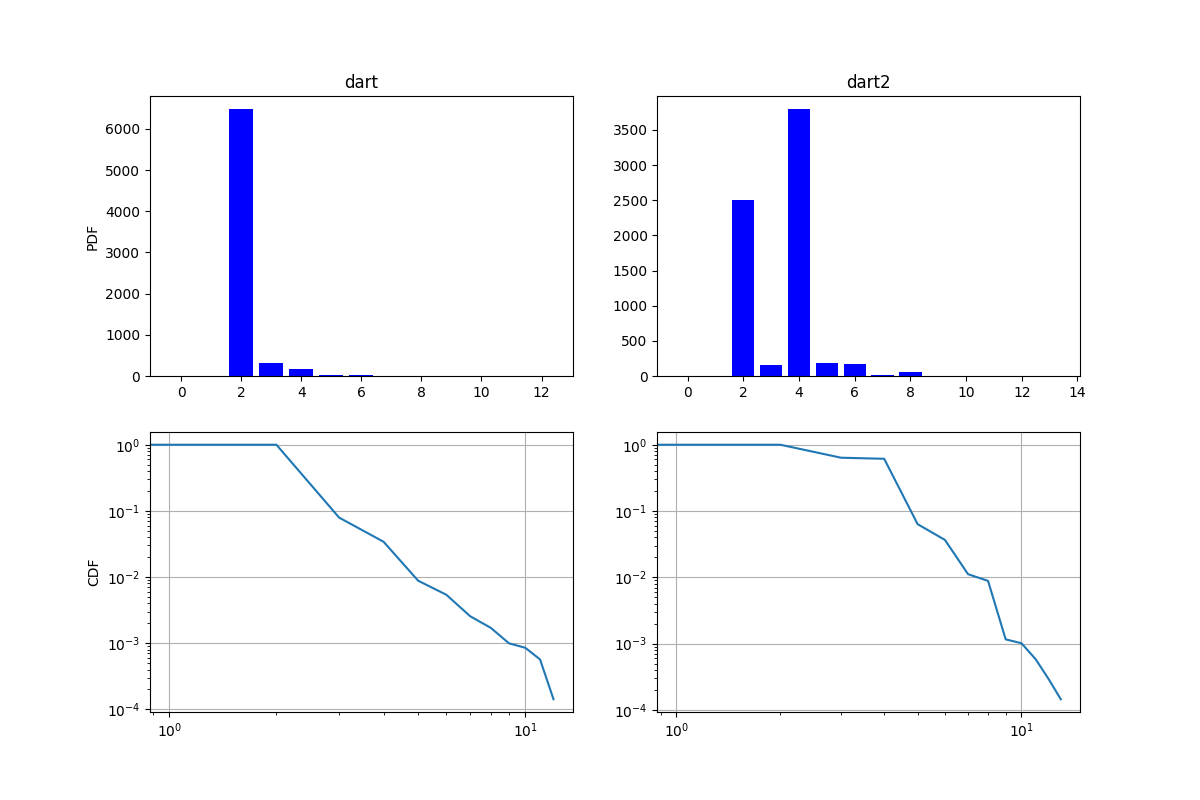

In [22]:
calc_powerlaw_multi({"dart": G, "dart2": G2})
plt.show()

In [55]:
# Reload powerlaw (if necessary)
# del calc_powerlaw_multi
import dcns.pathfinding
import importlib
importlib.reload(dcns.pathfinding)

<module 'dcns.pathfinding' from 'c:\\Users\\shaol\\source\\DCNS-S23-Project\\dcns\\pathfinding.py'>

In [56]:
G2_time = G_time.__class__(G_time.subgraph(max(nx.strongly_connected_components(G_time), key=len)))
# nx.set_edge_attributes(G2, nx.get_edge_attributes(G2, "num_trips"), "weight") 

In [57]:
G2_freq = G_freq.__class__(G_freq.subgraph(max(nx.strongly_connected_components(G_freq), key=len)))
# nx.set_edge_attributes(G2, nx.get_edge_attributes(G2, "num_trips"), "weight") 

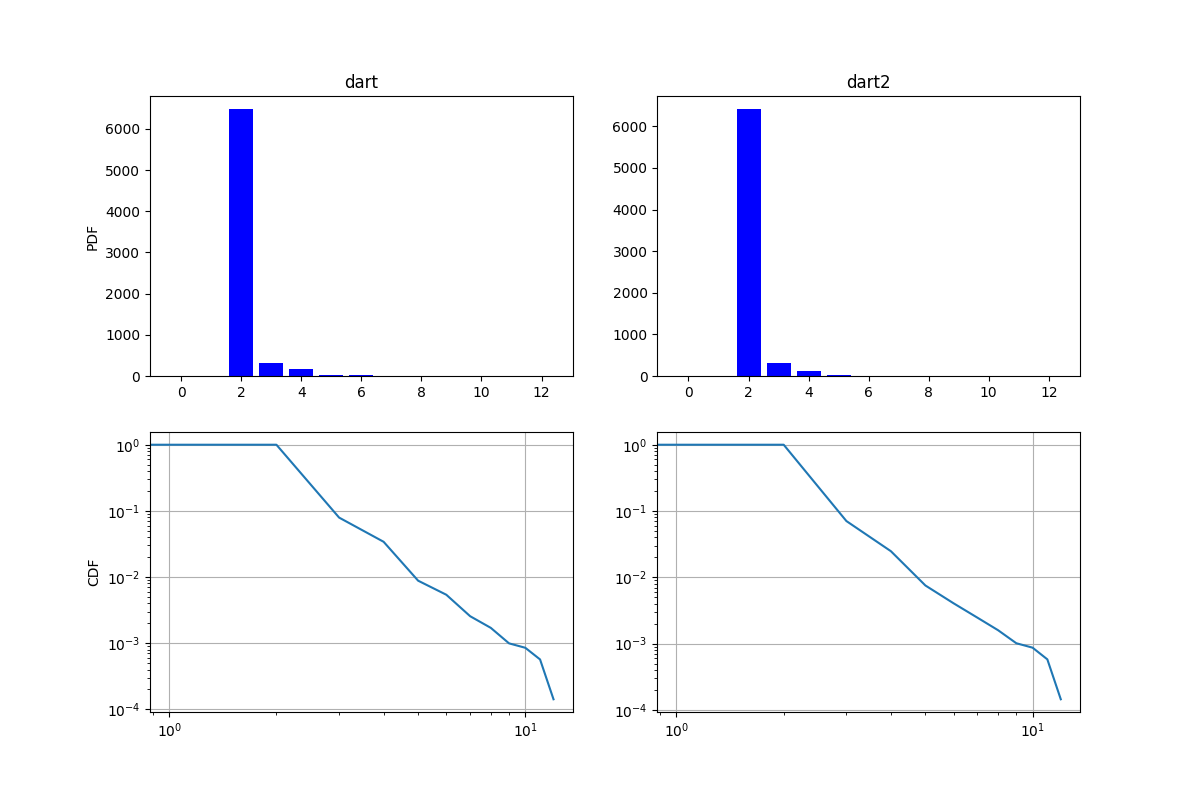

In [58]:
calc_powerlaw_multi({"dart": G_freq, "dart2": G2_freq})
plt.show()

In [59]:
from dcns.pathfinding import dijkstra, astar, astar_search, pathfind_steps

len(pathfind_steps(astar_search(G2_time, "30141", "31212"), "30141", "31212")[1])

2

In [60]:
from dcns.pathfinding import (
    dijkstra,
    astar,
    astar_search,
    pathfind_steps,
    astar_dist_search,
    astar_dist,
)


goals = [
    ("30141", "31212"),
    ("30140", "31212"),
    ("16516", "31212"),
    ("20527", "29291"),
    ("33302", "30496"),
    ("33286", "16971"),
]
# 30141 & 30140

start = goals[0][0]
end = goals[0][1]

len(astar(G2_time, start, end)[0])

117

In [5]:
from functools import partial
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def plot_graph(graph, pos, ax, min_edge_length=0.007, style=None):
    if style is None:
        style = {}
    # Only draw edges over a threshold for faster displaying
    edges = [
        (u, v)
        for u, v in graph.edges()
        if np.linalg.norm(pos[u] - pos[v]) > min_edge_length
    ]
    nx.draw_networkx_edges(
        graph,
        pos=pos,
        ax=ax,
        edgelist=edges,
        alpha=0.4,
        width=0.5,
        **style,
    )
    nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color="tab:blue", **style)
    ax.set_aspect("equal")


def plot_pathfinding(
    graph,
    search_func,
    start,
    end,
    min_edge_length=0.007,
):
    pos = nx.get_node_attributes(graph, "pos")

    steps = pathfind_steps(
        search_func(graph, start, end),
        start,
        end,
        sample_steps=(200, 10),
    )
    steps.insert(0, steps[0])  # Artificially extend the length of the first frame

    fig, ax = plt.subplots()

    def update(frame: int):
        if frame >= len(steps):
            return

        searched_nodes, path_nodes = steps[frame]

        # Draw the updated graph with new node colors
        nx.draw_networkx_nodes(
            graph,
            pos=pos,
            ax=ax,
            nodelist=searched_nodes,
            node_color="tab:orange",
            **style,
        )
        nx.draw_networkx_nodes(
            graph,
            pos=pos,
            ax=ax,
            nodelist=path_nodes,
            node_color="tab:green",
            **style,
        )

    # Create an animation object
    return FuncAnimation(
        fig,
        update,
        init_func=partial(
            plot_graph, graph, pos, ax, min_edge_length=min_edge_length, style=style
        ),
        interval=100,
        frames=len(steps) + 3,
        repeat=True,
    )



In [61]:
pos = nx.get_node_attributes(G2, "pos")
for start, end in goals:
    p, d, s = astar(G2, start, end, lambda u, v: np.linalg.norm(pos[u]-pos[v]))
    print(len(p), d, s)
print()

for start, end in goals:
    p, d, s = astar_dist(G3, start, end, nx.get_node_attributes(G3, "pos"))
    print(len(p), d, s)

MovieWriter imagemagick unavailable; using Pillow instead.


117 5244.559999999999 3891
78 4948.490000000001 4237
62 3306.6200000000003 3176
74 3983.8099999999995 1530
81 6841.490000000001 3672
77 3255.6800000000003 3066

71 4531.08 3381
32 4235.01 3562
16 2593.1400000000003 1516
32 3057.99 1020
81 6841.490000000001 4090
75 3572.879999999999 4019


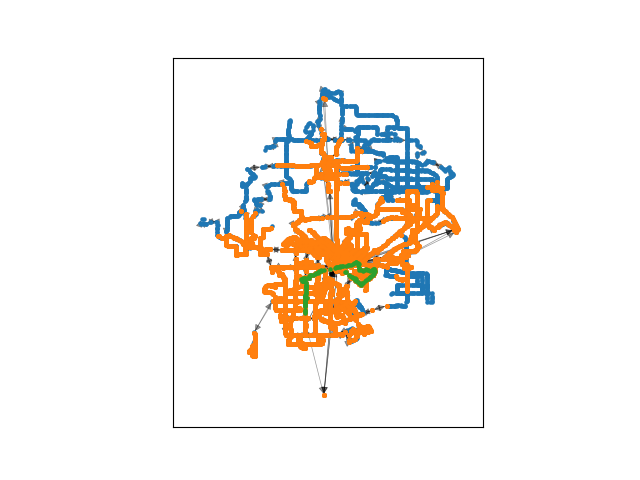

In [8]:
anim = plot_pathfinding(
    G2,
    astar_dist_search,
    goals[0][0],
    goals[0][1],
    min_edge_length=0.007,
)

# Note: for this to work, you must have ImageMagick installed on your computer AND you
# must set to the path to `convert.exe` (ImageMagick < 7.x) or `magick.exe` for
# (ImageMagick >= 7.x) in the `matplotlibrc` file.
#
# animation.convert_path: C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe
#
# See: https://matplotlib.org/stable/tutorials/introductory/customizing.html
anim.save("./images/astar_dist.gif", writer="imagemagick", fps=10)

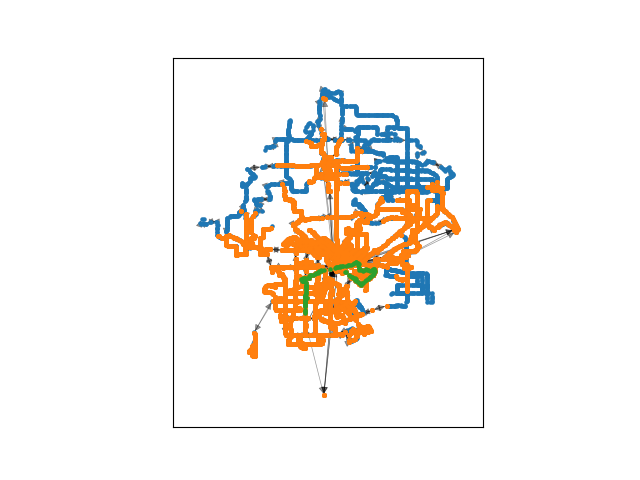

In [8]:
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random

fig, ax = plt.subplots()

pos_time = nx.get_node_attributes(G_time, "pos")
pos_freq = nx.get_node_attributes(G_freq, "pos")

steps = pathfind_steps(
    astar_search(G2_time, "30141", "31212"), "30141", "31212", sample_steps=(200, 10)
)
style = {"node_size": 5}
print(len(steps))


def init():
    # Only draw edges over a threshold for faster displaying
    edges = [(u, v) for u, v in G2_time.edges() if np.linalg.norm(pos[u] - pos[v]) > 0.007]
    nx.draw_networkx_edges(
        G2_time,
        pos=pos,
        ax=ax,
        edgelist=edges,
        alpha=0.4,
        width=0.5,
        **style,
    )
    ax.set_aspect("equal")

    # Draw nodes
    nx.draw_networkx_nodes(G2_time, pos=pos_time, ax=ax, node_color="tab:blue", node_size=5)


def update(frame: int):
    if frame >= len(steps):
        return

    searched_nodes, path_nodes = steps[frame]

    # Draw the updated graph with new node colors
    nx.draw_networkx_nodes(
        G2_time,
        pos=pos_time,
        ax=ax,
        nodelist=searched_nodes,
        node_color="tab:orange",
        node_size=5,
    )
    nx.draw_networkx_nodes(
        G2_time,
        pos=pos_time,
        ax=ax,
        nodelist=path_nodes,
        node_color="tab:green",
        node_size=5,
    )


# Create an animation object
anim = FuncAnimation(
    fig, update, init_func=init, interval=100, frames=len(steps) + 3, repeat=True
)

# Note: for this to work, you must have ImageMagick installed on your computer AND you
# must set to the path to `convert.exe` (ImageMagick < 7.x) or `magick.exe` for
# (ImageMagick >= 7.x) in the `matplotlibrc` file.
#
# animation.convert_path: C:\Program Files\ImageMagick-7.1.1-Q16-HDRI\magick.exe
#
# See: https://matplotlib.org/stable/tutorials/introductory/customizing.html
anim.save("./images/astar_dist.gif", writer="imagemagick", fps=10)

In [62]:
anim.save("./anim.gif", writer="imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


In [63]:
HTML(anim.to_jshtml())

In [64]:
close_edges = get_close_edges(nx.get_node_attributes(G2_time, "pos"), 0.0005, 50)
# Add 2-way edges for crossing the street
weight=1000
G2_time.add_weighted_edges_from(ebunch_to_add={(u, v, weight) for u, v in close_edges})
G2_time.add_weighted_edges_from(ebunch_to_add={(v, u, weight) for u, v in close_edges})

100%|Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†| 2500/2500 [00:05<00:00, 480.15it/s]


In [17]:
G3 = G2.__class__(G2)
close_edges = get_close_edges(nx.get_node_attributes(G3, "pos"), 0.0005, 50)
# Add 2-way edges for crossing the street
weight=1000
G3.add_weighted_edges_from(ebunch_to_add={(u, v, weight) for u, v in close_edges})
G3.add_weighted_edges_from(ebunch_to_add={(v, u, weight) for u, v in close_edges})

100%|ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ ÃƒÂ¢Ã¢â‚¬â€œÃ‹â€ | 2500/2500 [00:07<00:00, 333.52it/s]


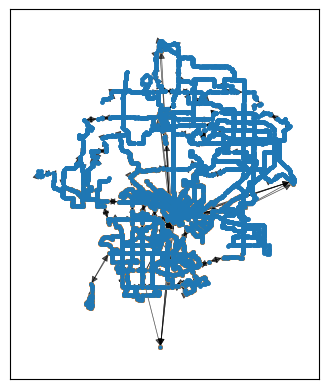

: 

In [121]:
anim2 = plot_pathfinding(
    G3,
    astar_dist_search,
    goals[0][0],
    goals[0][1],
    min_edge_length=0.007,
)
HTML(anim2.to_jshtml())

In [65]:
close_edges = get_close_edges(nx.get_node_attributes(G2_freq, "pos"), 0.0005, 50)
# Add 2-way edges for crossing the street
weight = 1e6
G2_freq.add_weighted_edges_from(ebunch_to_add={(u, v, weight) for u, v in close_edges})
G2_freq.add_weighted_edges_from(ebunch_to_add={(v, u, weight) for u, v in close_edges})

100%|Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†Ã¢â€“Ë†| 2500/2500 [00:10<00:00, 245.84it/s]


In [66]:
%matplotlib widget
nx.draw(G2_time, pos=pos_time, node_size=5, width=0.5, with_labels=False)

In [ ]:
def graph_diffusion(G: D3Graph, c: float, x0: float, delay=0):
    # L = D - A
    L = nx.laplacian_matrix(G).toarray().T
    N = G.number_of_nodes()

    x = np.zeros(N)
    x[0] = x0

    # Equilibrium state
    min_eigvec = get_min_eigenvector(L)
    x_equilibrium = min_eigvec / min_eigvec[0] * la.norm(x) / N
    # x_equilibrium = np.ones(N) * la.norm(x) / N

    x_dist = np.zeros(time.shape[0])

    # at each time step update the value of x!
    for i, t in enumerate(time):
        # Distance is the magnitude of the difference of states.
        x_dist[i] = la.norm(x - x_equilibrium)

        # dx/dt = -cLx
        x += c * -L @ x * dt

        yield x

    return x_dist

def update_diffusion(frame: int, ):
    ...

anim_diffusion = FuncAnimation(
    fig,
    update,
    init_func=partial(
        plot_graph, graph, pos, ax, min_edge_length=min_edge_length
    ),
    interval=100,
    frames=len(steps) + 3,
    repeat=True,
)

In [8]:
v = nx.katz_centrality(G2)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('20431', 0.024121808470581017),
 ('33245', 0.017330884066566143),
 ('33221', 0.01712656145339903),
 ('14071', 0.017077081909343667),
 ('33229', 0.016748426512332305)]

In [15]:
v = nx.eigenvector_centrality(G_freq)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('28264', 0.5368265196350608),
 ('22749', 0.4591515527756928),
 ('22748', 0.45889848812278444),
 ('28172', 0.2501210784473024),
 ('29825', 0.24689415583573063)]

In [67]:
nx.diameter(G2_time)
# Diameter = 356

200

In [68]:
nx.is_tree(G2_time)

False

In [69]:
# Centrality
# G_freq is a directed graph and is what we will be analyzing in this section
# Functions
stops = pd.read_csv("./data/gtfs-dart-2023-02-28/stops.txt")

def print_top_5(G,v,s=stops, num=5):
    thenodes = list(G.nodes())
    idx_list = [(i,v[i]) for i in range(len(v))]
    idx_list = sorted(idx_list, key = lambda x: x[1], reverse=True)
    for i in range(min(num,len(idx_list))):
        nidx, score = idx_list[i]
        print('  %i. %s (%1.4f)' % (i+1,s[s.stop_id == int(thenodes[nidx])].stop_name,score))
        #print '  %i. %s' % (i+1,G.node_object(idx))

def centrality_vector(G,d):
    thenodes = list(G.nodes())
    v = np.zeros((G.number_of_nodes(),))
    for i,u in enumerate(thenodes):
        v[i] = d[u]
    return v

def node_index(G,n):
    thenodes = list(G.nodes())
    return thenodes.index(n)

# Degree centrality
d = {}
for n in G_freq.nodes():
    d[n] = G_freq.degree(n)
v_degree = centrality_vector(G_freq,d)
d2 = {'node': list(G_freq.nodes()), 'degree': list(v_degree)}
df_degree = pd.DataFrame(data=d2)
print("Degree centrality:")
print_top_5(G_freq,v_degree)
print("\n")

# Eigenvector centrality
d = nx.eigenvector_centrality(G_freq,tol=1e-3,weight='weight')
v_eig = centrality_vector(G_freq,d)
d2 = {'node': list(G_freq.nodes()), 'degree': list(v_eig)}
df_eig = pd.DataFrame(data=d2)
print("Eigenvector centrality:")
print_top_5(G_freq,v_eig)
print("\n")

# Katz centrality
d = nx.katz_centrality(G_freq,0.001,0.01,tol=1e-3,weight='weight')
v_katz = centrality_vector(G_freq,d)
d2 = {'node': list(G_freq.nodes()), 'degree': list(v_katz)}
df_katz = pd.DataFrame(data=d2)
print("Katz centrality:")
print_top_5(G_freq,v_katz)
print("\n")

Degree centrality:
  1. 6557    SOUTHWEST MEDICAL DISTRICT/PARKLAND
Name: stop_name, dtype: object (12.0000)
  2. 3116    ELM @ HARWOOD - W - NS
Name: stop_name, dtype: object (11.0000)
  3. 6518    SOUTH GARLAND TC
Name: stop_name, dtype: object (11.0000)
  4. 6534    ADDISON TRANSIT CENTER
Name: stop_name, dtype: object (11.0000)
  5. 6524    DOWNTOWN IRVING/HERITAGE CROSSING STATION
Name: stop_name, dtype: object (10.0000)


Eigenvector centrality:
  1. 2190    ELM @ LAMAR - W - NS
Name: stop_name, dtype: object (0.4900)
  2. 2021    ELM @ GRIFFIN - W - MB
Name: stop_name, dtype: object (0.4434)
  3. 1937    ELM @ FIELD - W - FS
Name: stop_name, dtype: object (0.3686)
  4. 6575    CBD WEST TC
Name: stop_name, dtype: object (0.2446)
  5. 1674    ELM @ AUSTIN - W - NS
Name: stop_name, dtype: object (0.2408)


Katz centrality:
  1. 1937    ELM @ FIELD - W - FS
Name: stop_name, dtype: object (0.0770)
  2. 2021    ELM @ GRIFFIN - W - MB
Name: stop_name, dtype: object (0.0762)
  3. 2190  

In [70]:
# Betweenness centrality
# Highly related to percolation
# 3 MINUTES 40 SECONDS!!!!

d = nx.betweenness_centrality(G_time,weight='weight')
v_betweenness = centrality_vector(G_time,d)
print("Betweenness centrality:")
print_top_5(G_time,v_betweenness,num=10)
print("\n")

Betweenness centrality:
  1. 6534    ADDISON TRANSIT CENTER
Name: stop_name, dtype: object (0.2342)
  2. 6518    SOUTH GARLAND TC
Name: stop_name, dtype: object (0.1816)
  3. 5644    MOODY @ PEARL - E - NS
Name: stop_name, dtype: object (0.1688)
  4. 6557    SOUTHWEST MEDICAL DISTRICT/PARKLAND
Name: stop_name, dtype: object (0.1645)
  5. 1618    COMMERCE @ FIELD - E - FS
Name: stop_name, dtype: object (0.1634)
  6. 6493    COMMERCE @ ERVAY - E - MB
Name: stop_name, dtype: object (0.1628)
  7. 3114    COMMERCE @ LANE - E - NS
Name: stop_name, dtype: object (0.1628)
  8. 1937    ELM @ FIELD - W - FS
Name: stop_name, dtype: object (0.1596)
  9. 1673    ELM @ AKARD - W - NS
Name: stop_name, dtype: object (0.1596)
  10. 940    ELM @ ERVAY - W - NS
Name: stop_name, dtype: object (0.1547)




In [4]:
# Clustering

# Local clustering coefficients
d = {}
for n in G_time.nodes():
    d[n] = nx.clustering(G_time,nodes=n,weight=None)
list_degrees = [G_time.degree(n) for n in G_time.nodes()]
list_clustering = [d[n] for n in G_time.nodes()]

d2 = {'degree': list_degrees, 'clustering_coeff': list_clustering}
df = pd.DataFrame(data=d2)

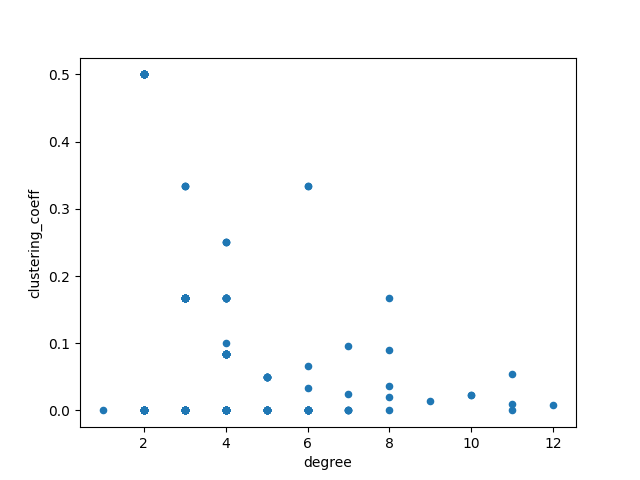

In [5]:
# Clustering
%matplotlib widget
df.plot(kind='scatter', x='degree' ,y='clustering_coeff')
plt.show()

In [73]:
# Cocitation and bibliography


In [74]:
# Communities
G2_freq_undir = G2_freq.to_undirected(reciprocal=False)
d_communities = nx.community.asyn_lpa_communities(G2_freq_undir,weight='weight')
# for c in d_communities:
#     print(list(c))